In [49]:
import geopandas as gpd
import pandas as pd

import mapillary as mly

import glob

from datetime import datetime



### osm-netzwerk einlesen

In [50]:
#set_date = "251010" 
#set_date = "251022" 
set_date = "251029" 


cycleways=gpd.read_parquet(f"processed_osm_files/processed_cycleways_germany_{set_date}.parquet")
motorways=gpd.read_parquet(f"processed_osm_files/processed_motorways_germany_{set_date}.parquet")

print("number of cycleways:", len(cycleways))
print("number of motorways:", len(motorways))

number of cycleways: 5442617
number of motorways: 69781


In [51]:
cycleways.head()

,osm_id,highway,bicycle,bicycle_forward,bicycle_backward,cycleway,cycleway_left,cycleway_right,cycleway_both,cycleway_lane,...,maxspeed,maxspeed_conditional,maxspeed_backward,maxspeed_forward,maxspeed_type,name,ref,surface,width,geometry
0,99,tertiary,None,None,None,None,None,no,None,None,...,None,None,None,None,None,None,None,asphalt,None,"LINESTRING (11.36639 48.17411, 11.36643 48.174..."
1,104,unclassified,None,None,None,None,None,None,no,None,...,50,None,None,None,None,Münzmeisterstraße,None,asphalt,None,"LINESTRING (13.74142 51.02366, 13.74139 51.023..."
2,105,residential,None,None,None,None,None,None,no,None,...,30,None,None,None,None,Altpestitz,None,sett,None,"LINESTRING (13.73698 51.01663, 13.73643 51.016..."
3,107,residential,None,None,None,None,None,None,no,None,...,30,None,None,None,None,Trienter Straße,None,asphalt,None,"LINESTRING (13.73507 51.01914, 13.73505 51.019..."
4,110,residential,None,None,None,None,None,None,no,None,...,50,None,None,None,sign,Heinrich-Greif-Straße,None,concrete:plates,None,"LINESTRING (13.74296 51.02871, 13.74295 51.028..."


In [52]:
cycleways.columns

Index(['osm_id', 'highway', 'bicycle', 'bicycle_forward', 'bicycle_backward',
       'cycleway', 'cycleway_left', 'cycleway_right', 'cycleway_both',
       'cycleway_lane', 'cycleway_track', 'cycleway_opposite',
       'cycleway_shared_lane', 'sidewalk_right_bicycle',
       'sidewalk_left_bicycle', 'sidewalk_both_bicycle', 'maxspeed',
       'maxspeed_conditional', 'maxspeed_backward', 'maxspeed_forward',
       'maxspeed_type', 'name', 'ref', 'surface', 'width', 'geometry'],
      dtype='object')

In [53]:
filtered_cycleways = cycleways[
    (cycleways["bicycle"].isin(["designated"])) |
    (cycleways["bicycle_backward"].isin(["designated"])) |
    (cycleways["bicycle_forward"].isin(["designated"])) |
    (cycleways["highway"].isin(["cycleway"])) |
    (cycleways["cycleway"].notnull() & (cycleways["cycleway"] != "no")) |
    (cycleways["cycleway_left"].notnull() & (cycleways["cycleway_left"] != "no")) |
    (cycleways["cycleway_right"].notnull() & (cycleways["cycleway_right"] != "no")) |
    (cycleways["cycleway_both"].notnull() & (cycleways["cycleway_both"] != "no")) |
    (cycleways["cycleway_lane"].notnull() & (cycleways["cycleway_lane"] != "no")) |
    (cycleways["cycleway_track"].notnull() & (cycleways["cycleway_track"] != "no")) |
    # (cycleways["sidewalk_bicycle"].isin(["designated"])) |  TODO: add "sidewalk:bicycle" in ini file
    (cycleways["sidewalk_right_bicycle"].isin(["designated"])) |
    (cycleways["sidewalk_left_bicycle"].isin(["designated"])) |
    (cycleways["sidewalk_both_bicycle"].isin(["designated"])) 
]
len(filtered_cycleways)

766598

In [54]:
#filtered_cycleways[::10].plot()

In [55]:
# # Lade lk
# lk = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/refs/heads/main/4_kreise/1_sehr_hoch.geo.json")
# #lk[lk.NAME_3 == "Ravensburg"].plot()

# sel_lk = lk[lk.NAME_3 == "Berlin"]
# sel_lk=sel_lk.to_crs(filtered_cycleways.crs)
# filtered_cycleways_lk = filtered_cycleways.clip(sel_lk)

# filtered_cycleways_lk.plot()

In [56]:
#motorways.plot()

In [57]:
filtered_cycleways_proj = filtered_cycleways.to_crs(25833)
filtered_cycleways_proj["length_m"] = filtered_cycleways_proj.geometry.length
#filtered_cycleways_proj[["osm_id", "length_m"]]

total_km = filtered_cycleways_proj.length_m.sum() / 1000
print(f"Gesamtlänge der gefilterten 'Radinfra': {total_km:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".") + " km")

Gesamtlänge der gefilterten 'Radinfra': 137.950,66 km


In [58]:
#filtered_cycleways.highway.value_counts()

### mapillary traffic signs einlesen

In [ ]:


## TRAFFFIC SIGNS
# https://www.mapillary.com/developer/api-documentation/traffic-signs?locale=


### EINLESEN

# Find all parquet files in the tile_cache folder (per state)
parquet_files = glob.glob("../../output/*.parquet")
# Extract and print the dates from the filenames
dates = [f.split("_")[-1].replace(".parquet", "") for f in parquet_files]
# Drop all duplicates in the list
dates = list(set(dates))
print("Dates found in filenames:", dates)
# Read all files and concatenate into one GeoDataFrame
mapillary_trafficsigns = gpd.GeoDataFrame(
    pd.concat([gpd.read_parquet(f) for f in parquet_files], ignore_index=True),
    crs=gpd.read_parquet(parquet_files[0]).crs
)




### FILTERN

# Unterschiedliche Verkehrszeichen in Deutschland für Radwege

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:237
# Radweg
de_237="regulatory--bicycles-only--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:240
# Gemeinsamer Geh- und Radweg
de_240="regulatory--shared-path-pedestrians-and-bicycles--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:241-30
# Getrennter Rad- und Gehweg
de_241_30="regulatory--dual-path-bicycles-and-pedestrians--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:241-31
# Getrennter Rad- und Gehweg
de_241_31="regulatory--dual-path-pedestrians-and-bicycles--g1"


# ggf. noch  "complementary--except-bicycles--g1" https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:1022-10

# 2025-06-07 ## -> 184120 features
# 2025-07-30 ## -> 213732 features
# 2025-08-05 ## -> 214438 features
# 2025-09-08 ## -> 220510 features
# 2025-10-29 ## -> 224575 features

# filter to cw only
mapillary_trafficsigns_cw=mapillary_trafficsigns[mapillary_trafficsigns.value.isin([de_237, de_240, de_241_30, de_241_31])]
# drop duplicates if any
mapillary_trafficsigns_cw=mapillary_trafficsigns_cw.drop_duplicates(subset=['id'])

mapillary_trafficsigns_cw




Dates found in filenames: ['2025-10-29']


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
1,POINT (6.69476 53.59648),2022-10-18,766428184457863,2022-10-18,regulatory--shared-path-pedestrians-and-bicycl...,8496,5291
2,POINT (6.68792 53.59318),2017-01-02,290013722802236,2017-01-02,regulatory--shared-path-pedestrians-and-bicycl...,8496,5291
6,POINT (6.69946 53.5974),2022-10-18,644562370527925,2022-10-18,regulatory--shared-path-pedestrians-and-bicycl...,8496,5291
7,POINT (6.69048 53.59314),2017-01-02,189437229692972,2017-01-02,regulatory--shared-path-pedestrians-and-bicycl...,8496,5291
8,POINT (6.68795 53.5932),2017-01-02,289646422838966,2017-01-02,regulatory--bicycles-only--g1,8496,5291
...,...,...,...,...,...,...,...
6330228,POINT (7.36426 49.33184),2019-04-22,199565778655061,2019-04-22,regulatory--bicycles-only--g1,8527,5603
6330564,POINT (7.3841 49.36201),2016-02-26,966957547455761,2016-02-26,regulatory--shared-path-pedestrians-and-bicycl...,8528,5601
6330573,POINT (7.38416 49.36211),2020-05-20,230815512141642,2020-05-20,regulatory--shared-path-pedestrians-and-bicycl...,8528,5601
6330577,POINT (7.38464 49.36229),2016-02-26,322281759469783,2016-02-26,regulatory--bicycles-only--g1,8528,5601


<Axes: xlabel='last_seen_at'>

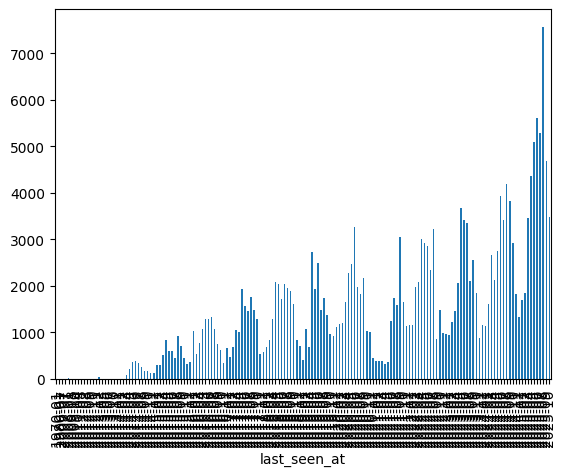

In [60]:
mapillary_trafficsigns_cw.last_seen_at.str[:-3].value_counts().sort_index().plot(kind="bar")


#### Zeitfilter 

In [61]:
##  is newer than 2025-01-01  

# september 2025: 36488
# oktober   2025: 41263


mapillary_trafficsigns_cw=mapillary_trafficsigns_cw[mapillary_trafficsigns_cw["last_seen_at"] > "2025-01-01"]
# mapillary_trafficsigns_237_recent
len(mapillary_trafficsigns_cw)

43040

In [62]:
mapillary_trafficsigns_cw

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
1352,POINT (6.96977 52.50272),2025-07-11,1277830543914166,2025-07-11,regulatory--dual-path-bicycles-and-pedestrians...,8509,5374
1355,POINT (6.97087 52.50375),2025-07-11,1420873325722270,2025-07-11,regulatory--shared-path-pedestrians-and-bicycl...,8509,5374
1361,POINT (6.96945 52.50217),2025-07-11,1277830540580833,2025-07-11,regulatory--dual-path-bicycles-and-pedestrians...,8509,5374
1438,POINT (6.98752 52.63311),2025-07-17,3512000912263405,2025-07-17,regulatory--shared-path-pedestrians-and-bicycl...,8510,5364
1480,POINT (7.00238 52.51187),2025-07-11,718441690796424,2025-07-11,regulatory--shared-path-pedestrians-and-bicycl...,8510,5373
...,...,...,...,...,...,...,...
6319009,POINT (7.25935 49.31319),2025-05-17,1219926069857067,2025-05-17,regulatory--shared-path-pedestrians-and-bicycl...,8522,5604
6319106,POINT (7.25426 49.31444),2025-05-17,1142259607651419,2025-05-17,regulatory--shared-path-pedestrians-and-bicycl...,8522,5604
6319634,POINT (7.27225 49.30426),2025-02-26,963018202586959,2025-02-26,regulatory--bicycles-only--g1,8522,5605
6321411,POINT (7.27795 49.3458),2021-06-22,354848619379671,2025-06-12,regulatory--shared-path-pedestrians-and-bicycl...,8523,5602


<Axes: xlabel='last_seen_at'>

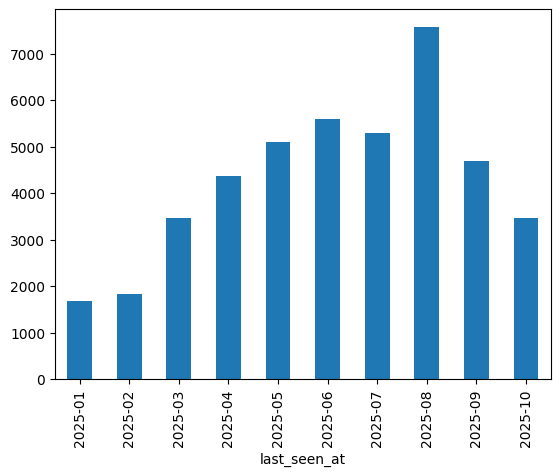

In [63]:
mapillary_trafficsigns_cw.last_seen_at.str[:-3].value_counts().sort_index().plot(kind="bar")


In [83]:
##  at least 12 months between first and last seen (to avoid temporary signs)
## might need to adjust this


zeitspanne = 9

def months_between(date1, date2):
    d1 = datetime.strptime(date1, "%Y-%m-%d")
    d2 = datetime.strptime(date2, "%Y-%m-%d")
    return abs((d2.year - d1.year) * 12 + d2.month - d1.month)

mapillary_trafficsigns_cw_temp = mapillary_trafficsigns_cw[
    mapillary_trafficsigns_cw.apply(lambda row: months_between(row['first_seen_at'], row['last_seen_at']) >= zeitspanne, axis=1)
]
len(mapillary_trafficsigns_cw_temp)

16985

<Axes: xlabel='last_seen_at'>

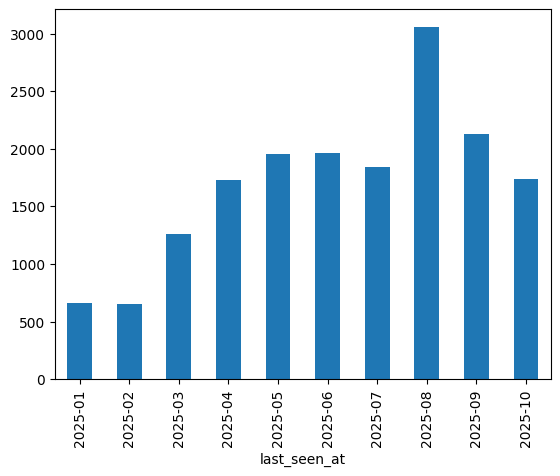

In [84]:
mapillary_trafficsigns_cw_temp.last_seen_at.str[:-3].value_counts().sort_index().plot(kind="bar")



<Axes: >

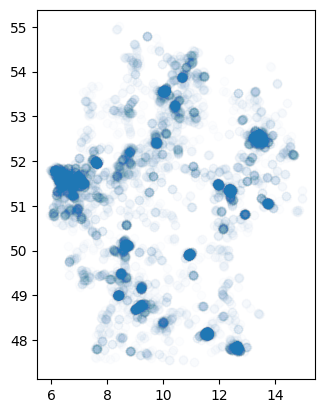

In [85]:
mapillary_trafficsigns_cw_temp.plot(alpha=0.01)

#### Räumliche Prüfung 

In [86]:
## now create a buffer around the traffic signs to check if there is a cycleway nearby
df_buffered_30 = mapillary_trafficsigns_cw_temp.to_crs(25833).copy()
df_buffered_25 = mapillary_trafficsigns_cw_temp.to_crs(25833).copy()

#df_buffered["geometry"] = df_buffered.geometry.buffer(50)
#df_buffered["geometry"] = df_buffered.geometry.buffer(40)
df_buffered_30["geometry"] = df_buffered_30.geometry.buffer(30)
df_buffered_25["geometry"] = df_buffered_25.geometry.buffer(25)


df_buffered_30 = df_buffered_30.to_crs(mapillary_trafficsigns_cw_temp.crs)
df_buffered_25 = df_buffered_25.to_crs(mapillary_trafficsigns_cw_temp.crs)


In [87]:
# helper 
def mark_intersections(buffered_df, target_layer, column_name="has_intersection"):
    """
    Marks which geometries in `buffered_df` intersect with `target_layer`.

    Parameters:
    - buffered_df (GeoDataFrame): The GeoDataFrame containing buffered geometries.
    - target_layer (GeoDataFrame): The GeoDataFrame to check for intersections (e.g., cycleways, motorways).
    - column_name (str): Name of the column to add/overwrite in `buffered_df` indicating intersection (bool).

    Returns:
    - GeoDataFrame: `buffered_df` with a new boolean column `column_name`.
    """
    # Ensure CRS matches
    buffered_df = buffered_df.to_crs(target_layer.crs)

    # Perform spatial join to find intersecting geometries
    joined = gpd.sjoin(buffered_df, target_layer, how="inner", predicate="intersects")

    # Initialize the new column to False
    buffered_df[column_name] = False

    # Set True for geometries that intersect
    matches = joined.index.unique()
    buffered_df.loc[matches, column_name] = True

    return buffered_df


In [88]:
# For cycleways
df_buffered_30 = mark_intersections(df_buffered_30, filtered_cycleways, column_name="has_cw_intersection")
df_buffered_25 = mark_intersections(df_buffered_25, filtered_cycleways, column_name="has_cw_intersection")



# For motorways (just 30m for both)
df_buffered_30 = mark_intersections(df_buffered_30, motorways, column_name="has_mw_intersection")
#df_buffered_20 = mark_intersections(df_buffered_30, motorways, column_name="has_mw_intersection")



In [89]:
df_buffered_30["buffer_size"] = 30
df_buffered_25["buffer_size"] = 25

In [90]:
#df_buffered.id.unique()

In [91]:
# An wie vielen Schilder ist ein Radweg in der Nähe?
df_buffered_30.has_cw_intersection.value_counts()

has_cw_intersection
True     16821
False      164
Name: count, dtype: int64

In [92]:
df_buffered_25.has_cw_intersection.value_counts()

has_cw_intersection
True     16793
False      192
Name: count, dtype: int64

In [93]:
# An wie vielen Schilder ist eine Autobahn in der Nähe?
df_buffered_30.has_mw_intersection.value_counts()

has_mw_intersection
False    16854
True       131
Name: count, dtype: int64

In [94]:
df_buffered_30.has_mw_intersection

1701       False
1731       False
1857       False
2005       False
2023       False
           ...  
6318512    False
6318531    False
6318652    False
6321411    False
6322955    False
Name: has_mw_intersection, Length: 16985, dtype: bool

In [95]:
df_buffered_25_false=df_buffered_25[(df_buffered_25.has_cw_intersection== False) & (df_buffered_30.has_mw_intersection== False)].copy()
len(df_buffered_25_false)

120

In [96]:
df_buffered_30_false=df_buffered_30[(df_buffered_30.has_cw_intersection== False) & (df_buffered_30.has_mw_intersection== False)].copy()
len(df_buffered_30_false)

92

In [97]:
df_buffered_25_false

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,buffer_size
7578,"POLYGON ((7.21754 53.35007, 7.21754 53.35005, ...",2024-11-19,1231584981502885,2025-08-27,regulatory--shared-path-pedestrians-and-bicycl...,8520,5310,False,25
16305,"POLYGON ((7.39103 53.07789, 7.39103 53.07787, ...",2018-09-27,292730299099210,2025-09-09,regulatory--dual-path-bicycles-and-pedestrians...,8528,5331,False,25
152145,"POLYGON ((9.18928 51.97381, 9.18928 51.97379, ...",2020-01-04,619323471095996,2025-09-29,regulatory--dual-path-bicycles-and-pedestrians...,8610,5413,False,25
209479,"POLYGON ((9.64284 52.39914, 9.64284 52.39912, ...",2019-09-25,4419183031439179,2025-10-20,regulatory--dual-path-bicycles-and-pedestrians...,8630,5382,False,25
558225,"POLYGON ((7.56444 47.80957, 7.56445 47.80955, ...",2019-05-27,160246089385049,2025-10-12,regulatory--shared-path-pedestrians-and-bicycl...,8536,5708,False,25
...,...,...,...,...,...,...,...,...,...
6061660,"POLYGON ((8.33849 51.66862, 8.3385 51.6686, 8....",2024-02-25,394575303453637,2025-02-15,regulatory--bicycles-only--g1,8571,5436,False,25
6119095,"POLYGON ((8.60345 51.67233, 8.60345 51.67231, ...",2023-04-08,1134468127961308,2025-07-03,regulatory--bicycles-only--g1,8583,5436,False,25
6119242,"POLYGON ((8.60722 51.67428, 8.60722 51.67426, ...",2023-04-08,868968794713940,2025-05-15,regulatory--bicycles-only--g1,8583,5435,False,25
6126954,"POLYGON ((8.64199 51.62139, 8.64199 51.62137, ...",2024-10-21,1595450354387450,2025-07-03,regulatory--shared-path-pedestrians-and-bicycl...,8585,5439,False,25


In [98]:
df_buffered_both_false= pd.concat([df_buffered_30_false, df_buffered_25_false]).sort_values("buffer_size").drop_duplicates(subset=['id'],keep="last")
df_buffered_both_false["buffer_size"].value_counts()

buffer_size
30    92
25    28
Name: count, dtype: int64

priority bei MapRoulette:

| Wert | Bedeutung         |
| ---- | ----------------- |
| 0    | High              |
| 1    | Medium (Standard) |
| 2    | Low               |


In [99]:
df_buffered_both_false["prio"] = df_buffered_both_false["buffer_size"].map({25: 1, 30: 0}).astype("Int64")

In [100]:
df_buffered_both_false

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio
558225,"POLYGON ((7.56444 47.80957, 7.56445 47.80955, ...",2019-05-27,160246089385049,2025-10-12,regulatory--shared-path-pedestrians-and-bicycl...,8536,5708,False,NaN,25,1
715119,"POLYGON ((8.50196 47.95726, 8.50196 47.95723, ...",2021-09-20,1238963863274619,2025-07-16,regulatory--shared-path-pedestrians-and-bicycl...,8578,5698,False,NaN,25,1
1296167,"POLYGON ((9.89394 48.91584, 9.89394 48.91582, ...",2024-11-25,1295642021488461,2025-09-13,regulatory--shared-path-pedestrians-and-bicycl...,8642,5632,False,NaN,25,1
1508403,"POLYGON ((10.59149 49.49943, 10.59149 49.49941...",2019-08-04,311528303763928,2025-07-18,regulatory--shared-path-pedestrians-and-bicycl...,8674,5591,False,NaN,25,1
2265482,"POLYGON ((12.97882 47.84199, 12.97882 47.84197...",2024-10-02,1643390686240585,2025-08-14,regulatory--bicycles-only--g1,8782,5706,False,NaN,25,1
...,...,...,...,...,...,...,...,...,...,...,...
2185243,"POLYGON ((12.48413 47.81701, 12.48412 47.81698...",2024-05-05,290238127489572,2025-07-13,regulatory--shared-path-pedestrians-and-bicycl...,8760,5707,False,False,30,0
1186928,"POLYGON ((9.3616 48.64943, 9.36161 48.64941, 9...",2022-07-31,2841097756197569,2025-07-29,regulatory--shared-path-pedestrians-and-bicycl...,8618,5650,False,False,30,0
1183630,"POLYGON ((9.36137 48.87018, 9.36137 48.87016, ...",2024-04-08,1129066038517150,2025-03-29,regulatory--shared-path-pedestrians-and-bicycl...,8618,5635,False,False,30,0
1172024,"POLYGON ((9.32277 47.72535, 9.32277 47.72532, ...",2020-01-10,778543676382616,2025-07-04,regulatory--shared-path-pedestrians-and-bicycl...,8616,5713,False,False,30,0


In [101]:
# interactive map
# df_buffered_false.explore(
#     color="red",
#     tiles="CartoDB positron",
#     popup=True,
#     tooltip=["value", "first_seen_at", "last_seen_at"]
# )

#### clean up from existing maproulette challenge

In [102]:
### import the the flagged (not created, fixed) tasks from the challenge. 

challenge_gdf = gpd.read_file("challenge_52916_data_f_mr.geojson")
#challenge_gdf.head()

df_buffered_both_false = df_buffered_both_false.to_crs(4326)

# Find intersections
intersections = gpd.sjoin(df_buffered_both_false, challenge_gdf, how="left", predicate="intersects")

# Keep only rows that do NOT intersect (i.e., no match in challenge_gdf)
df_buffered_both_false_no_challenge = df_buffered_both_false.loc[intersections.index[intersections["index_right"].isna()]] 

len(df_buffered_both_false_no_challenge)


73

### retrieve the image ID for the map features

In [103]:
#df_process_img= df_buffered_false.copy()
df_process_img= df_buffered_both_false_no_challenge.copy()

In [104]:
import sys
import os
import json
import logging
from contextlib import contextmanager
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# ---------------------------------------------------------------


# -- suppress stdout context manager --
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# -- Load config & set Mapillary token --
with open("config_mapillary_privat.json", "r") as f:
    config = json.load(f)

access_token = config["ACCESS_TOKEN"]
mly.interface.set_access_token(access_token)

# -- Logging cleanup --
for name in logging.root.manager.loggerDict:
    logging.getLogger(name).setLevel(logging.WARNING)
logging.basicConfig(level=logging.ERROR)

# -- Your image fetching function --
def get_image_id(map_feature_id):
    try:
        feature_str = mly.interface.feature_from_key(key=str(map_feature_id))
        feature = json.loads(feature_str)
        images = feature["features"]["properties"]["images"]["data"]
        return images[-1]["id"] if images else None
    except Exception as e:
        return None  # Or log the error if needed

# -- Parallelized version using ThreadPoolExecutor --
def parallel_get_image_ids(ids, max_workers=8):
    results = [None] * len(ids)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(get_image_id, id_): idx for idx, id_ in enumerate(ids)}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching image IDs"):
            idx = futures[future]
            try:
                results[idx] = future.result()
            except Exception:
                results[idx] = None  # Or log
    return results

# -- Apply to your dataframe --
with suppress_stdout():
    df_process_img["image_id"] = parallel_get_image_ids(df_process_img["id"].tolist(), max_workers=5)  # Adjust max_workers as needed, 5 is fastest for me


Fetching image IDs: 100%|██████████| 73/73 [00:15<00:00,  4.75it/s]


In [105]:
## https://www.mapillary.com/app/?pKey=1029316554880692

df_process_img.head()



,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio,image_id
558225,"POLYGON ((7.56444 47.80957, 7.56445 47.80955, ...",2019-05-27,160246089385049,2025-10-12,regulatory--shared-path-pedestrians-and-bicycl...,8536,5708,False,NaN,25,1,116418193833414
715119,"POLYGON ((8.50196 47.95726, 8.50196 47.95723, ...",2021-09-20,1238963863274619,2025-07-16,regulatory--shared-path-pedestrians-and-bicycl...,8578,5698,False,NaN,25,1,1820797981449100
1296167,"POLYGON ((9.89394 48.91584, 9.89394 48.91582, ...",2024-11-25,1295642021488461,2025-09-13,regulatory--shared-path-pedestrians-and-bicycl...,8642,5632,False,NaN,25,1,605747075420421
1508403,"POLYGON ((10.59149 49.49943, 10.59149 49.49941...",2019-08-04,311528303763928,2025-07-18,regulatory--shared-path-pedestrians-and-bicycl...,8674,5591,False,NaN,25,1,891427081423044
2265482,"POLYGON ((12.97882 47.84199, 12.97882 47.84197...",2024-10-02,1643390686240585,2025-08-14,regulatory--bicycles-only--g1,8782,5706,False,NaN,25,1,1291561008416607


In [106]:
# to points, to 4326

centroids = df_process_img.copy()
centroids=centroids.to_crs(25832)
centroids["geometry"] = centroids.geometry.centroid
centroids=centroids.to_crs(4326)

centroids.sort_values("last_seen_at")


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio,image_id
2264576,POINT (12.97226 47.84328),2024-05-22,984772746363859,2025-02-11,regulatory--shared-path-pedestrians-and-bicycl...,8782,5705,False,False,30,0,1861388247621359
2264795,POINT (12.97199 47.84332),2024-05-22,984772716363862,2025-02-11,regulatory--shared-path-pedestrians-and-bicycl...,8782,5705,False,False,30,0,1553899215173321
2932055,POINT (10.11079 53.53959),2024-06-16,1443818199609900,2025-03-17,regulatory--bicycles-only--g1,8652,5296,False,False,30,0,959570815894063
2180129,POINT (12.46538 47.77464),2024-05-01,822500396409723,2025-03-22,regulatory--shared-path-pedestrians-and-bicycl...,8759,5710,False,False,30,0,1459397558023845
5997391,POINT (7.77564 51.17388),2024-04-12,1234888207472986,2025-03-25,regulatory--shared-path-pedestrians-and-bicycl...,8545,5472,False,False,30,0,965232961858887
...,...,...,...,...,...,...,...,...,...,...,...,...
5164828,POINT (6.47698 51.58884),2024-07-18,842999731127062,2025-10-14,regulatory--shared-path-pedestrians-and-bicycl...,8486,5442,False,False,30,0,524650033320419
2307025,POINT (6.73776 49.81897),2023-09-11,634801568474017,2025-10-15,regulatory--shared-path-pedestrians-and-bicycl...,8498,5569,False,False,30,0,227545459947189
3372483,POINT (8.81187 50.14686),2024-09-10,529340416413785,2025-10-17,regulatory--dual-path-pedestrians-and-bicycles...,8593,5546,False,False,30,0,890019503180737
4290427,POINT (12.38309 51.34332),2024-12-02,601383029481959,2025-10-17,regulatory--bicycles-only--g1,8755,5460,False,NaN,25,1,2188015128351934


In [107]:
# Mapping dictionary
value_to_vz = {
    'regulatory--dual-path-pedestrians-and-bicycles--g1': 241,
    'regulatory--dual-path-bicycles-and-pedestrians--g1': 241,
    'regulatory--bicycles-only--g1': 237,
    'regulatory--shared-path-pedestrians-and-bicycles--g1': 240
}

# Add new column based on mapping
centroids["VZ"] = centroids["value"].map(value_to_vz)

In [108]:
#centroids

In [109]:
centroids

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio,image_id,VZ
558225,POINT (7.56411 47.80955),2019-05-27,160246089385049,2025-10-12,regulatory--shared-path-pedestrians-and-bicycl...,8536,5708,False,NaN,25,1,116418193833414,240
715119,POINT (8.50163 47.95724),2021-09-20,1238963863274619,2025-07-16,regulatory--shared-path-pedestrians-and-bicycl...,8578,5698,False,NaN,25,1,1820797981449100,240
1296167,POINT (9.8936 48.91582),2024-11-25,1295642021488461,2025-09-13,regulatory--shared-path-pedestrians-and-bicycl...,8642,5632,False,NaN,25,1,605747075420421,240
1508403,POINT (10.59115 49.49942),2019-08-04,311528303763928,2025-07-18,regulatory--shared-path-pedestrians-and-bicycl...,8674,5591,False,NaN,25,1,891427081423044,240
2265482,POINT (12.97849 47.84199),2024-10-02,1643390686240585,2025-08-14,regulatory--bicycles-only--g1,8782,5706,False,NaN,25,1,1291561008416607,237
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2226448,POINT (12.65158 47.76877),2023-09-01,135199079619088,2025-08-27,regulatory--shared-path-pedestrians-and-bicycl...,8767,5711,False,False,30,0,1733345747127490,240
2222081,POINT (12.6351 47.82719),2018-03-04,303930607891277,2025-07-20,regulatory--bicycles-only--g1,8767,5707,False,False,30,0,959098904847002,237
2194233,POINT (12.56249 48.43369),2024-07-02,1225800432188914,2025-06-11,regulatory--shared-path-pedestrians-and-bicycl...,8763,5665,False,False,30,0,2796129390686640,240
1186928,POINT (9.3612 48.64941),2022-07-31,2841097756197569,2025-07-29,regulatory--shared-path-pedestrians-and-bicycl...,8618,5650,False,False,30,0,793012908777450,240


In [110]:
centroids["prio_text"] = centroids["prio"].map({
    0: "🟩 Task mit hoher Wahrscheinlichkeit valide",
    1: "🟨 Task mit mittlerer Wahrscheinlichkeit valide",
    2: "🟥 Task mit eher geringer Wahrscheinlichkeit valide"
})

centroids[["prio", "prio_text"]].head()

,prio,prio_text
558225,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
715119,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
1296167,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
1508403,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
2265482,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide


In [111]:
#centroids.plot()

In [112]:
import uuid

def to_maproulette_geojson_with_links(gdf, id_field="id", name_field="value", image_field="image_id"):
    features = []

    for _, row in gdf.iterrows():
        geom = row.geometry
        centroid = geom.centroid
        lat, lon = round(centroid.y, 6), round(centroid.x, 6)

        # Optional: Mapillary image
        image_url = None
        image_id = None
        if pd.notna(row.get(image_field)):
            image_id = str(int(row[image_field]))
            image_url = (
                f"https://www.mapillary.com/app/?pKey={image_id}"
                "&focus=photo"
                "&trafficSign[]=regulatory--bicycles-only--g1"
                "&trafficSign[]=regulatory--shared-path-pedestrians-and-bicycles--g1"
                "&trafficSign[]=regulatory--dual-path-bicycles-and-pedestrians--g1"
                "&trafficSign[]=regulatory--dual-path-pedestrians-and-bicycles--g1"
            )

        # TILDA link
        tilda_url = f"https://tilda-geo.de/regionen/radinfra?map=17.4/{lat}/{lon}&config=pdqyyt.7h3d.16g9vk&v=2&data=mapillary-cycleway-traffic-signs"

#         # Build instruction
        instruction = f"""  
### 🚧 Aufgabe: Verkehrszeichen **DE:{row["VZ"]}** überprüfen und Radinfra hinzufügen
Bitte schaue dir den Bereich rund um dieses erkannte Verkehrszeichen an. Vermutlich fehlt hier eine Radinfrastruktur, die du hinzufügen kannst. Die nächste OSM-Radinfra ist mind. **{row["buffer_size"]} Meter** entfernt.

---

### 🖼️ Bild & Karte

- 📷 [**Mapillary-Bild anzeigen**]({image_url})  
(Hinweis: Das zuerst angezeigte Bild ist wahrscheinlich nicht das neueste – die neueste Aufnahme hier ist von **{row["last_seen_at"]})**

- 🗺️ [**In radinfra.de bzw TILDA ansehen**]({tilda_url})  
(Hinweis: Ist hilfreich um den aktuellen Stand der Radinfrastruktur vor Ort zu prüfen.)

---

### 📚 Nützliche Links

- 🛑 [**Traffic Sign Tool** – DE:{row["VZ"]}](https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:{row["VZ"]})  
- 🚴 [**OSM-Wiki: Radverkehrsanlagen kartieren**](https://wiki.openstreetmap.org/wiki/DE:Bicycle/Radverkehrsanlagen_kartieren)

---

Viel Erfolg beim Prüfen und Mappen! 🗺️
        """

        # Build properties
        props = {
            #"identifier": str(row[id_field]),
            "image_id": image_id,
            "Verkehrzeichen": str(row["VZ"]),
            "instruction": instruction,   #.strip(),
            "priority":  row["prio"],
            "name": row["prio_text"]
        }

        # Build feature
        feature = {
            "type": "Feature",
            "geometry": row["geometry"].__geo_interface__,
            "properties": props,
            # Set the top-level ID here
            "id":  str(row[id_field]), # detection Id
           # "priority":  row["prio"] 
        }

        # # Add Mapillary attachment if available
        # if image_id:
        #     feature["attachments"] = [
        #         {
        #             "id": str(uuid.uuid4()),
        #             "kind": "referencePhoto",
        #             "type": "mapillary",
        #             "format": "image",
        #             "data": image_id
        #         }
        #     ]

        features.append(feature)

    return {
        "type": "FeatureCollection",
        "features": features
    }


In [113]:
# Convert your df_buffered_false (or any GeoDataFrame) to GeoJSON
maproulette_geojson = to_maproulette_geojson_with_links(centroids)

# Save to file
with open("maproulette_tasks_missing-cw_instruction_vz_name_new.geojson", "w") as f:
    json.dump(maproulette_geojson, f, indent=2)


In [ ]:
### Maproulette stuff....

In [ ]:
## Add missing cycleways based on mapillary signs (Germany)


## 🚲 Fehlende Radwege anhand von Mapillary-Verkehrszeichen ergänzen (Deutschland)

Diese Challenge basiert auf automatisch erkannten, radverkehrsbezogenen Verkehrszeichen aus Mapillary-Bildern in Deutschland.

### 📌 Kriterien für jede Aufgabe

Nur Aufgaben, die **alle** folgenden Bedingungen erfüllen, wurden berücksichtigt:

- Das Verkehrszeichen wurde **in Mapillary erkannt**.
- Es handelt sich um ein **radverkehrsbezogenes Zeichen**  
  *(z. B. gemeinsamer Geh- und Radweg, reiner Radweg, getrennter Geh-/Radweg)*.
- Das Zeichen wurde **mindestens 12 Monate lang regelmäßig gesehen**.
- Die neuste Aufnahme stammt **aus dem Jahr 2025**.
- Es existiert **kein OSM-"Radweg" innerhalb von 30 m** des Standortes.

---

### 🔍 Was du tun solltest

1. Öffne den Ort in **Mapillary** und **radinfra.de** sowie einem Editor.
2. Prüfe, ob an der Stelle eine **Radinfrastruktur fehlt**.
3. Falls ja, ergänze die passenden OSM-Tags:  
   z. B. `highway=cycleway`, `cycleway=*`, `bicycle=designated`, etc.
4. Wenn bereits alles korrekt gemappt ist, kannst du die Aufgabe einfach **als erledigt markieren**.

---

🗺️ Vielen Dank für deine Hilfe beim Ausbau der Radinfrastruktur in OSM!

In [ ]:
'''
{{instruction}}
                                                                                             .
'''